### Validate trained policy offline

In [19]:
import torch
import os
import numpy as np
import cv2
import collections
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import sys
sys.path.append('../../hannes-imitation')
sys.path.append('../../hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import dict_apply

# hannes_imitation imports
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset
from hannes_imitation.common import plot_utils
from hannes_imitation.common.data_utils import resize_image

In [ ]:
# load dataset
merged_dir = '/home/calessi-iit.local/Projects/hannes-imitation/data/preliminary/'
merged_name = 'merged.zarr'
zarr_path = os.path.join(merged_dir, merged_name)
keys = ['image_in_hand', 'ref_move_hand']
val_ratio = 0.1
seed = 72
max_train_episodes = None
horizon = 16 # prediction horizon
observation_horizon = 2
action_horizon = 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
train_dataset = HannesImageDataset(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)
validation_dataset = train_dataset.get_validation_dataset()

In [9]:
# load model
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy.pth'
checkpoint = torch.load(policy_path)

policy = checkpoint['policy']

In [10]:
# device transfer
device = torch.device('cuda')
_ = policy.to(device).eval()

In [11]:
# choose episode
episode = train_dataset.replay_buffer.get_episode(1)
frames = episode['image_in_hand']
actions_gt = episode['ref_move_hand']

episode_len, height, width, _ = frames.shape

sampling_frequency = 20 # Hz NOTE we decided this based on hand frequency and camera frequency

frames.shape, actions_gt.shape

((118, 96, 128, 3), (118, 1))

In [13]:
# evaluate policy on episode
action_trajectories = []

# NOTE: copy this loop also for inference on real robot
frames_deque = collections.deque(iterable=[], maxlen=observation_horizon) # (B=1, To, C, H, W)

for i in range(episode_len):
    # read image, preprocess image, insert image in deque
    image = frames[i] # read_image
    image = np.moveaxis(image, source=-1, destination=0) # move Channel dimension first
    image = image.astype(np.float32) / 255.0

    # append image to deque
    # at the beginning the frames deque is empty. If it is the first iteration, fill the deque with copies of the first frame
    frames_deque.append(image)    
    while len(frames_deque) < frames_deque.maxlen:
        frames_deque.append(image)

    # create observation dictionary 
    obs_dict = {'image_in_hand': np.expand_dims(frames_deque, axis=0)} # include batch size in first dimension
    obs_dict = dict_apply(obs_dict, torch.from_numpy)

    # predict action trajectory
    action_predictions = policy.predict_action(obs_dict) # {'action', 'action_pred}
    action_trajectory = action_predictions['action'] # (B, Ta, Da)

    action_trajectories.append(action_trajectory.cpu().detach().numpy()) 

In [14]:
action_trajectories = np.array(action_trajectories).reshape(episode_len, action_horizon, -1) # remove batch dimension (episode len, Ta, Da)
#action_trajectories = np.round(action_trajectories) # convert to integers [0-100] ?
action_trajectories.shape

(118, 8, 1)

#### Action error over time

```python
action_error_0 = np.mean(np.abs(actions_gt - action_trajectories[:, 0]), axis=1) # no horizon
action_error_1 = np.mean(np.abs(actions_gt[1:] - action_trajectories[:-1, 1]), axis=1) # horizon 1
action_error_2 = np.mean(np.abs(actions_gt[2:] - action_trajectories[:-2, 2]), axis=1) # horizon 2
```

Idea illustrated below (sample time goes right, prediction horizon goes down): [x means that that index is ignored]

for horizon 0 (i.e. 1 step prediction)
- actions_gt      [a0, a1, a2, a3, ..., aN]
- actions_pred_h0 [a00, a10, a20, a30, ... aN0] 

for horizon 1 (i.e., 2 step prediciton)
- actions_gt      [x, a1, a2, a3, ..., a_N]
- actions_pred_h1 [a01, a11, a21, ..., a_(N-1,1), x] 

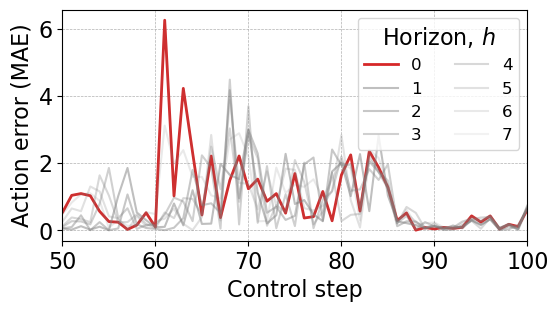

In [17]:
action_errors_horizon = {h: None for h in range(action_horizon)}
for h in range(action_horizon):
    a_gt_horizon = actions_gt[h:] # skip the first h actions to get ground truth with horizon h
    if h > 0:
        a_pred_horizon = action_trajectories[:-h, h] # skip last h samples but take the prediction with horizon h starting from the first sample
    else:
        a_pred_horizon = action_trajectories[:, h] # NOTE: this because [:-0] does not work as expected

    # average over action dimension
    action_errors_horizon[h] = np.mean(np.abs(a_gt_horizon - a_pred_horizon), axis=1) # (episode_len, 1)


alphas = np.ones(action_horizon)
alphas[1:] = np.linspace(0.5, 0.1, num=action_horizon-1)

plt.figure(figsize=(6,3))
plt.plot(action_errors_horizon[h], color='tab:red', linewidth=2, alpha=alphas[0], label='0')

for h in range(1, action_horizon):
    plt.plot(action_errors_horizon[h], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
plt.ylabel("Action error (MAE)")

plt.grid(linewidth=0.5, linestyle='--')
plt.legend(title='Horizon, $h$', loc='best', ncols=2)
plt.xlim([50, 100]) # break axis?
plt.show()

### Reference vs predicted actions

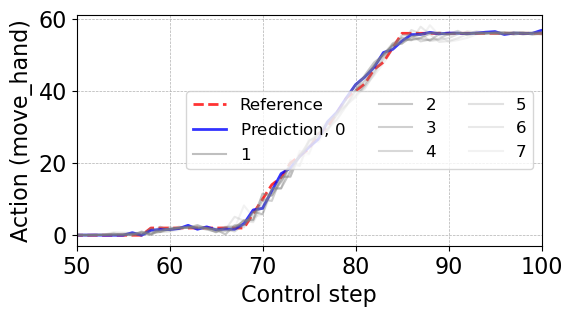

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(actions_gt, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')
plt.plot(np.arange(0, episode_len), action_trajectories[:, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction, $0$')

for h in range(1, action_horizon):
    time_axis = np.arange(h, episode_len)
    plt.plot(time_axis, action_trajectories[:-h, h], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
plt.ylabel("Action (move_hand)")

plt.grid(linewidth=0.5, linestyle='--')
plt.xlim([50, 100]) # break axis?

plt.legend(loc='best', ncols=3)
#plt.savefig(fname='../figures/learning_curve.pdf', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.png', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.svg', bbox_inches='tight', dpi=600)
plt.show()

### Video (frames + predictions)

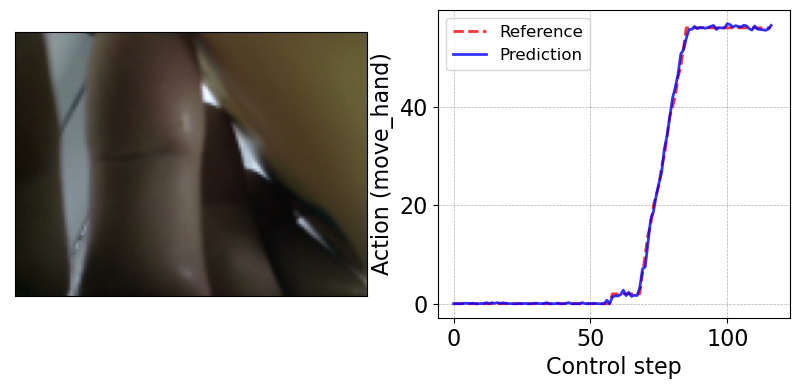

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

# images
line_img = ax1.imshow(resize_image(frames[0], 2))
ax1.set_xticks([])
ax1.set_yticks([])

# actions
line_action_gt = ax2.plot(np.arange(0, episode_len), actions_gt, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')[0]
line_action_pred = ax2.plot(np.arange(0, episode_len), action_trajectories[:, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction')[0]

ax2.set_xlabel("Control step")
ax2.set_ylabel("Action (move_hand)")
ax2.grid(linewidth=0.5, linestyle='--')
ax2.legend(loc='upper left', ncols=1)

# Initialize function
def init():
    line_img.set_data([[]])

    line_action_gt.set_data([], [])
    line_action_pred.set_data([], [])
    
    return line_img, line_action_gt, line_action_pred

# Update function
def update(frame):
    line_img.set_data(frames[frame])

    line_action_gt.set_data(np.arange(0, frame), actions_gt[:frame])
    line_action_pred.set_data(np.arange(0, frame), action_trajectories[:frame, 0])

    return line_img, line_action_gt, line_action_pred

# Create animation
ani = FuncAnimation(fig, update, frames=episode_len, init_func=init, blit=False)
ani.save("../figures/hannes_policy_evaluation_offline.mp4", writer="ffmpeg", fps=sampling_frequency, dpi=600)

plt.show()

#### Extra: Count parameters

In [5]:
# define function
count_parameters = lambda net: np.sum([np.prod(params.shape) for params in net.parameters()])

unet_count = count_parameters(policy.model)
resnet_count = count_parameters(policy.obs_encoder)

print("UNet parameters:", unet_count)
print("ResNet parameters:", resnet_count)

UNet parameters: 3156417
ResNet parameters: 11176512
